## Objective
* Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Data

* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer 
* CreditScore: It defines the credit history of the customer.  
* Geography: A customer’s location    
* Gender: It defines the Gender of the customer   
* Age: Age of the customer     
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
* EstimatedSalary: Estimated salary 
* isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
* Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )

## Importing Libraries

In [1]:
import tensorflow as tf
import timeit
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam 
import seaborn as sns
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Input, InputLayer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler


### Reading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data = pd.read_csv("/content/drive/My Drive/AIML/Churn.csv")
df = data.copy()

### Shape of Dataset

In [4]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns.")  # f-string


There are 10000 rows and 14 columns.


### View Dataset

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Checking Datatype

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- most cells are int, need to change Geography,HasCrCard, IsActiveMemeber, Exited and Gender to categorical variables

### Missing Value check

In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- no missing values

### Duplication check

In [8]:
df[df.duplicated()].count()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- no duplicated valus

### Dropping unecessary columns

In [9]:
df.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1,inplace=True)

- None of these columns are statistically relevant.
    * RowNumber matches the index
    * We have confirmed there are no duplicates so we dont need CustomerID
    * Surname is generally unique to a person and serves no purpose here

### Checking Categrocial data for errors and fixing datatypes

In [10]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [11]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [12]:
df['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [13]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [14]:
categorical_var = ['Geography','Gender','HasCrCard','IsActiveMember','Exited' ]
for colname in categorical_var:
    df[colname] = df[colname].astype('category')

#checking if properly changed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Geography        10000 non-null  category
 2   Gender           10000 non-null  category
 3   Age              10000 non-null  int64   
 4   Tenure           10000 non-null  int64   
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  int64   
 7   HasCrCard        10000 non-null  category
 8   IsActiveMember   10000 non-null  category
 9   EstimatedSalary  10000 non-null  float64 
 10  Exited           10000 non-null  category
dtypes: category(5), float64(2), int64(4)
memory usage: 518.2 KB


### Dataset Summary

In [15]:
df.median()

CreditScore           652.000
Age                    37.000
Tenure                  5.000
Balance             97198.540
NumOfProducts           1.000
EstimatedSalary    100193.915
dtype: float64

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


- Credit score shows a left skew
- Age shows a right skew
- Tenure is more normally distributed
- Balance shows large left skew
- NumOfProducts shows a rightskew
- Estimated salary shows slight left skew/more normal distribution

## EDA

### Univariate Analysis

In [17]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [18]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

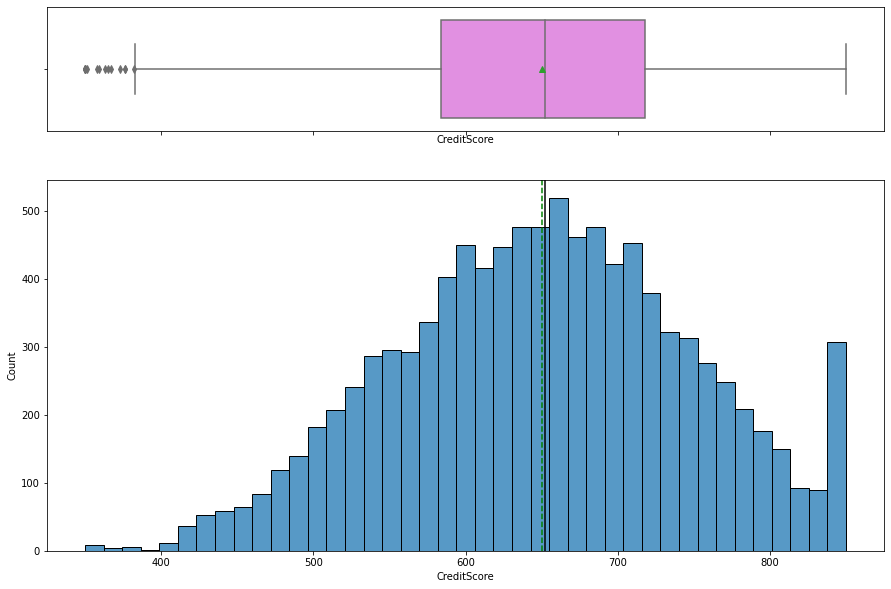

In [19]:
histogram_boxplot(df,"CreditScore")

- Outliers at lower ranges
- Left Skewed
- Third quartile is 718 so 75% of customers have a credit score less than 718

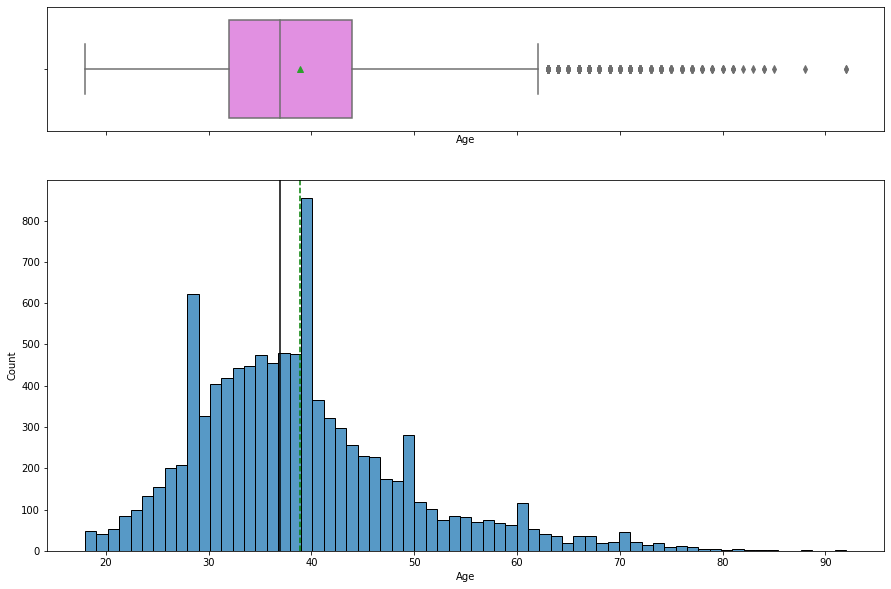

In [20]:
histogram_boxplot(df,"Age")

- Outliers at higher ranges
- Right Skewed
- Third quartile is 44 so 75% of customers aree 44 or less years old

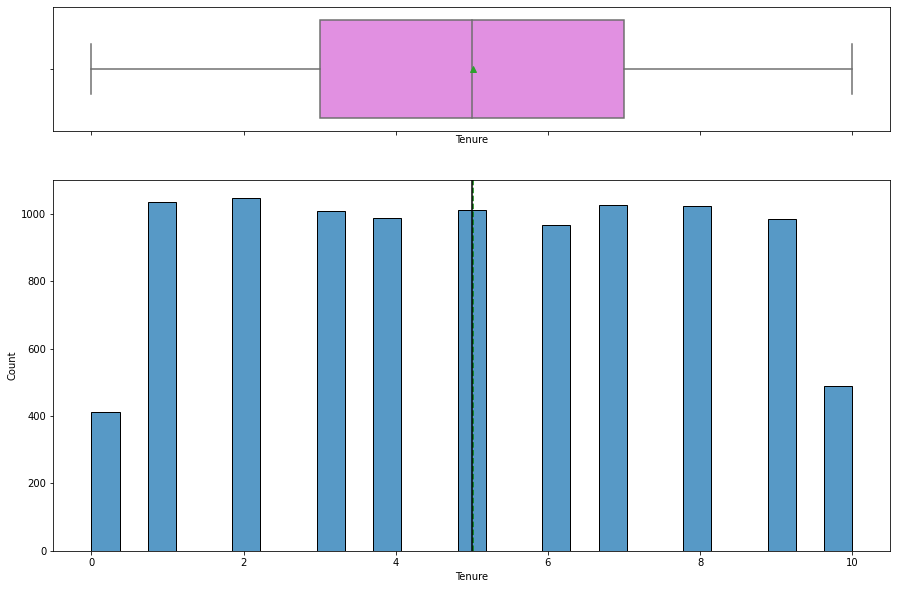

In [21]:
histogram_boxplot(df,"Tenure")

- No outliers
- Normal Distribution
- Third quartile is at 7 so 75% of customers had have a tenure of 7 years or less

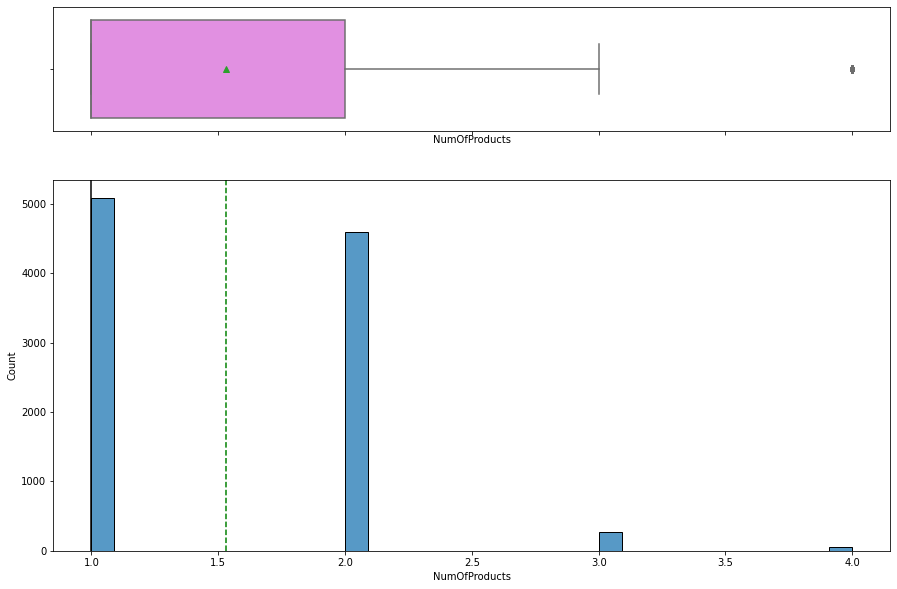

In [22]:
histogram_boxplot(df,"NumOfProducts")

- Small amount of outliers at higher range
- Right Skewed
- Third quartile is 2 so 75% of customers have 2 or less products

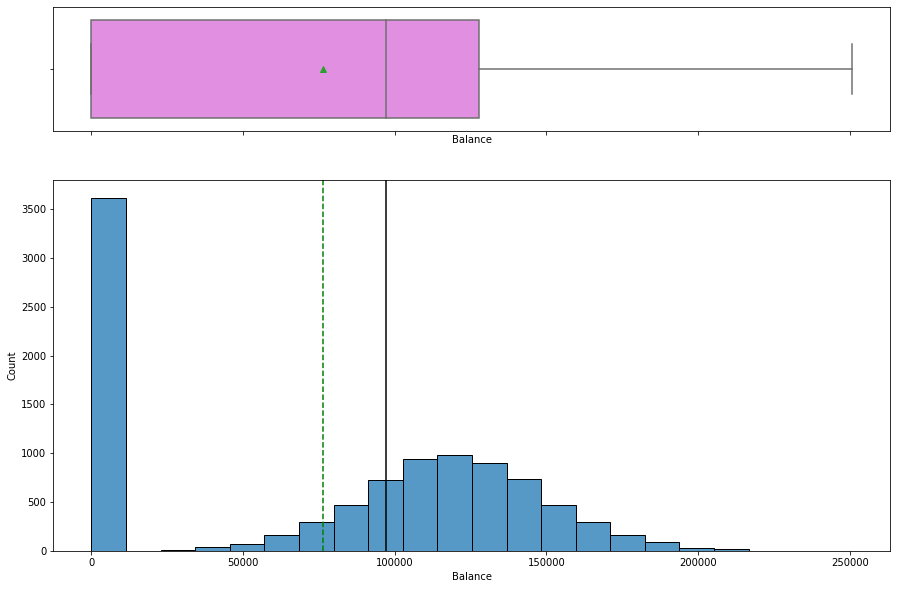

In [23]:
histogram_boxplot(df,"Balance")

- No outliers
- Heavy right skew
- Third quartile is 127644 so 75% of customers have a balance less than 127644 dollars

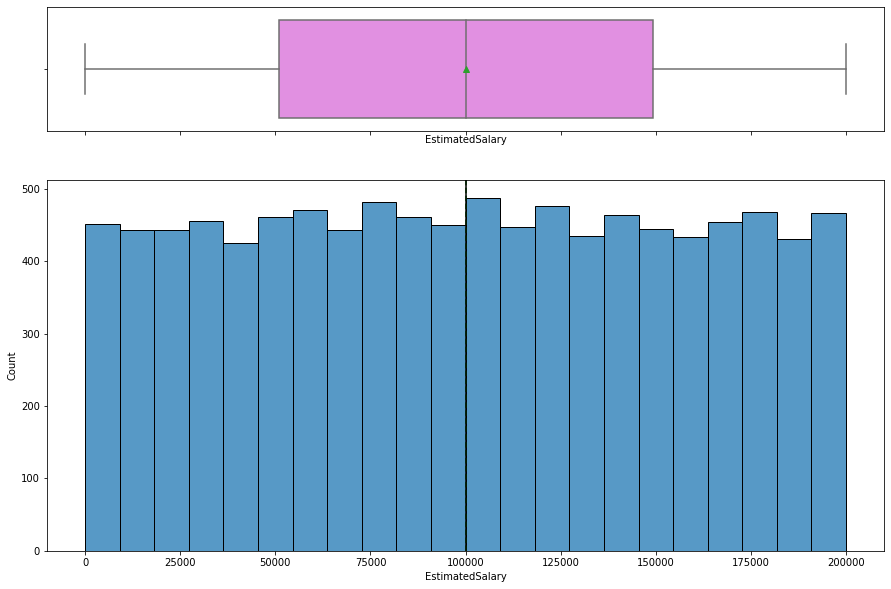

In [24]:
histogram_boxplot(df,"EstimatedSalary")

- No outliers
- More normally distributed
- Third quartile is 149388 so 75% of customers have an estimated salary less than 149388  dollars

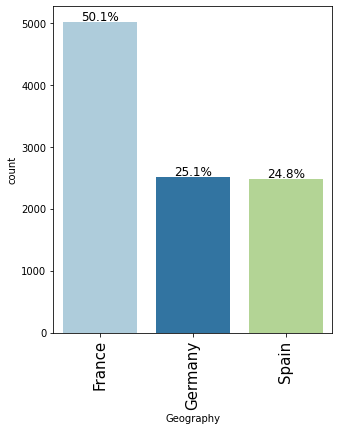

In [25]:
labeled_barplot(df,'Geography',perc=True)

- Most customers are from France(50.1%), followed by Germany(25.1%) then Spain(24.8%) which are closely tied.

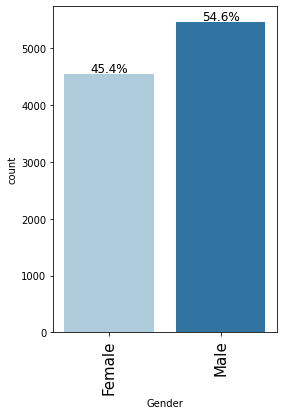

In [26]:
labeled_barplot(df,'Gender',perc=True)

- Most customers are Male (54.6%)

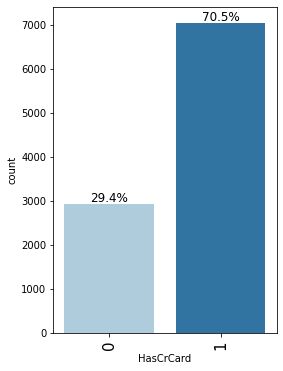

In [27]:
labeled_barplot(df,'HasCrCard',perc=True)

- Most customers have a credit card (70.5%)

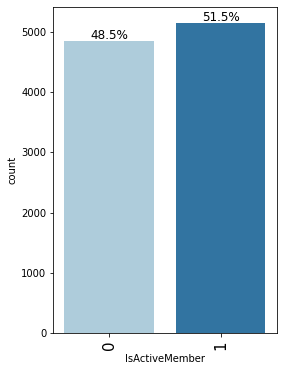

In [28]:
labeled_barplot(df,'IsActiveMember',perc=True)

- Most customers are active members (51.5%)

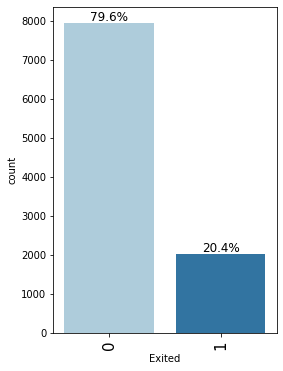

In [29]:
labeled_barplot(df,'Exited',perc=True)

- Most customers have not exited (79.6%)

### Bivariate Analysis

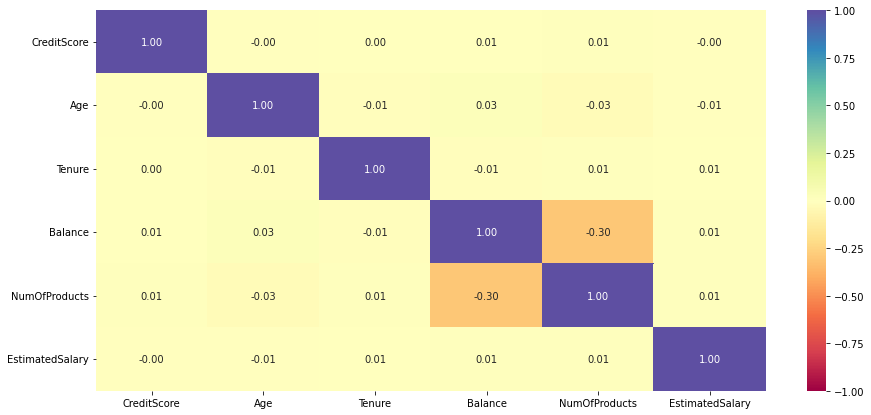

In [30]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()


- Balance and NumOfProduct show negative corellation
- Most variables show very slight correlations that are not significant

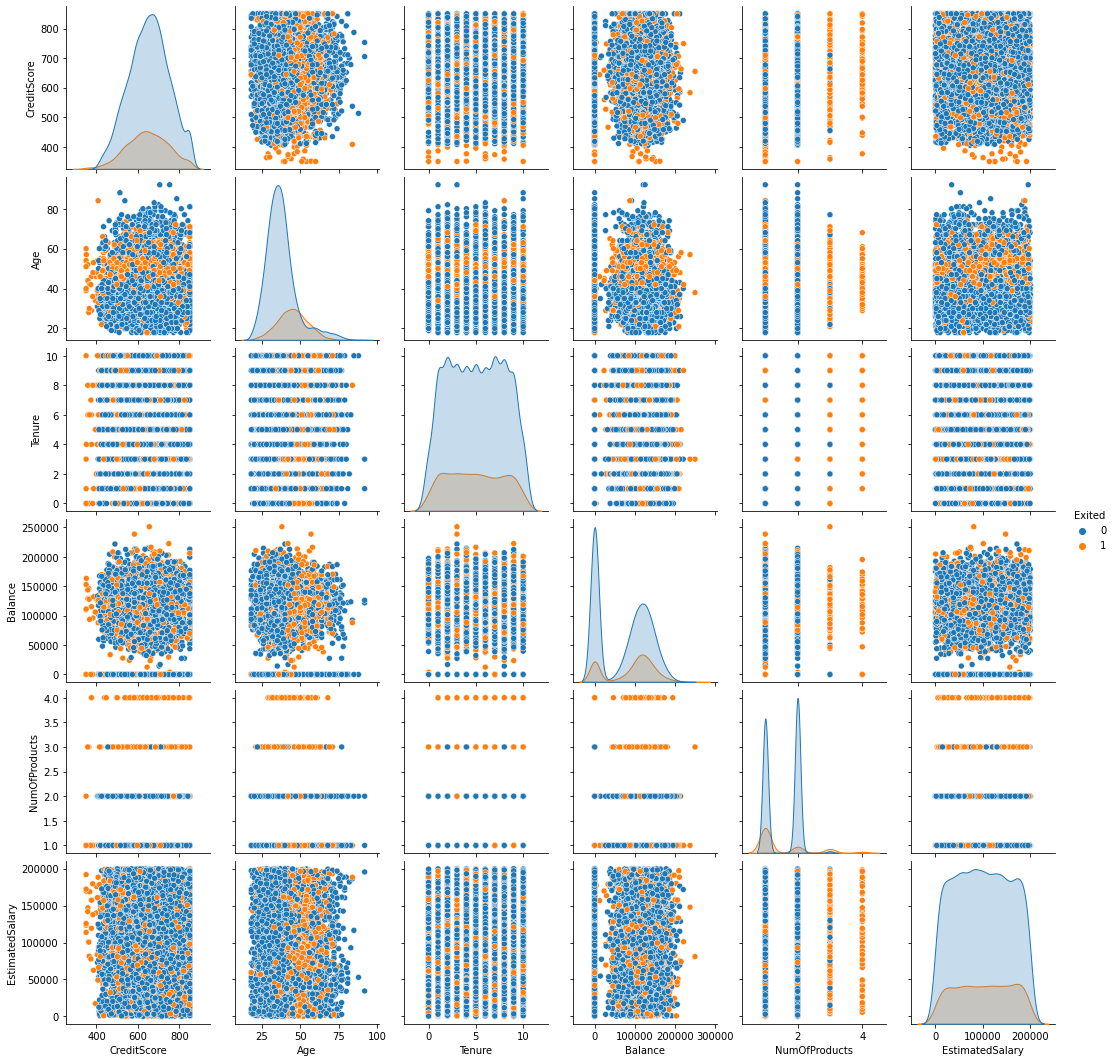

In [31]:
sns.pairplot(data=df, hue="Exited")
plt.show()

In [32]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


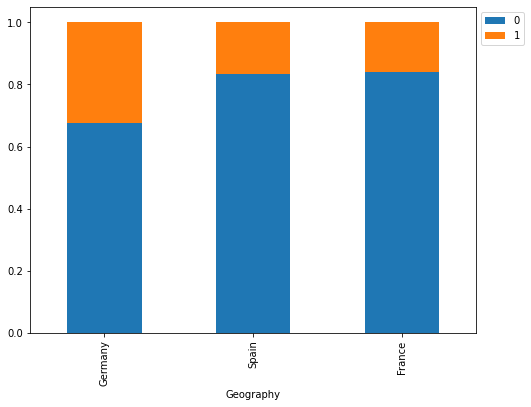

In [33]:
stacked_barplot(df,"Geography","Exited")

- Most customers that exited are from Germany
- Highest percent of customers that exited are also from Germany

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


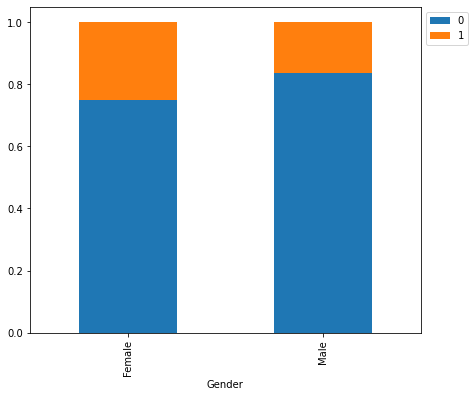

In [34]:
stacked_barplot(df,"Gender","Exited")

- Most customers that exited are from Female
- Highest percent of customers that exited are also Female

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


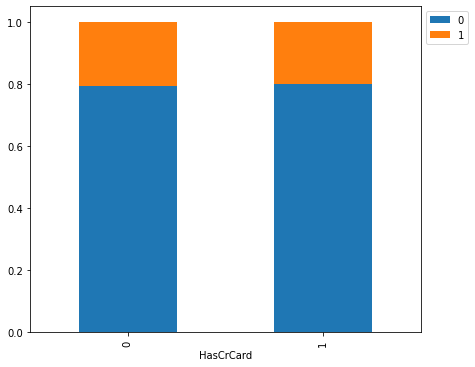

In [35]:
stacked_barplot(df,"HasCrCard","Exited")

- Most customers that exited have a credit card
- Highest percent of customers that exited are similar among both groups

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


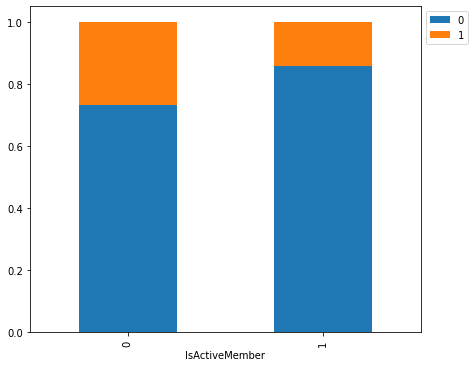

In [36]:
stacked_barplot(df,"IsActiveMember","Exited")

- Most customers that exited are not active members
- Highest percent of customers that exited are also not active members

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

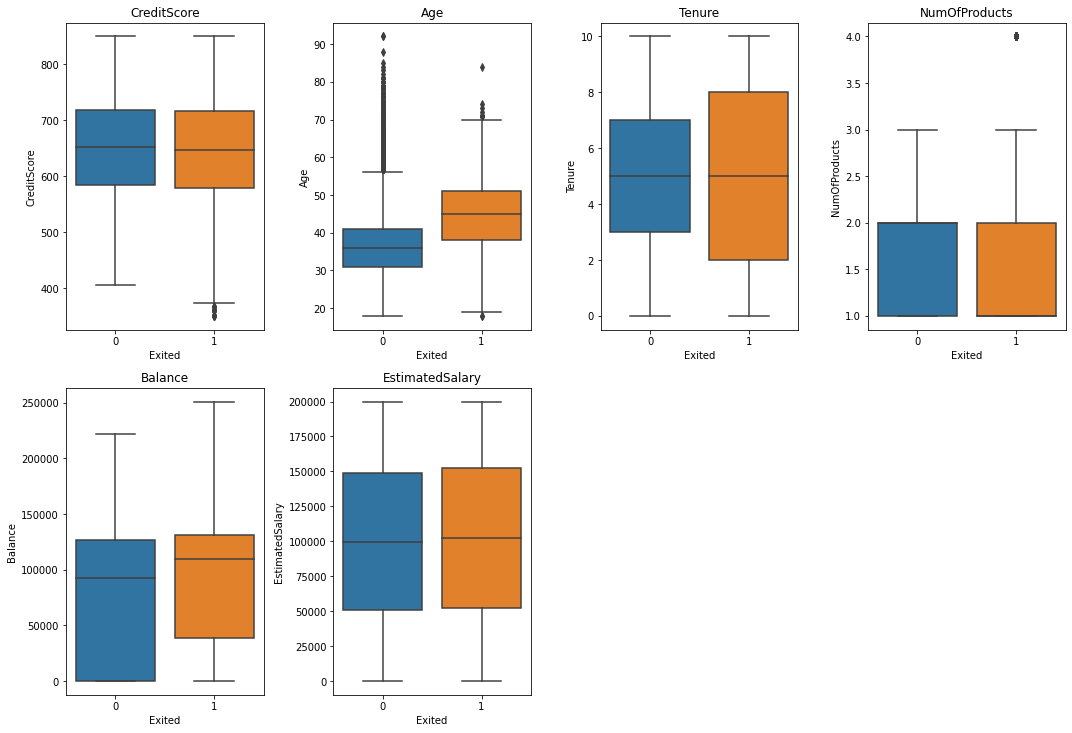

In [37]:
cols = df[
    [
        "CreditScore",
        "Age",
        "Tenure",
        "NumOfProducts",
        "Balance",
        "EstimatedSalary",

    ]
].columns.tolist()
plt.figure(figsize=(15, 20))

for i, variable in enumerate(cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(df["Exited"], df[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- Mean CredistScore is slightly lower among customers who exited, with a lower first quartile of credit score and similar third quartiles
- Mean age is much higher among customers who exited, distribution is much bigger as well with a slight higher first quartile and a much larger third quartile
- Mean Tenure is the same among customers who stayed and those that exited however the distribution is much bigger for those who exited even though they share the same range
- NumOfProducts share similar distributions, means and ranges among both groups
- Mean Valane is higher among cusotmers who exited, the range is also higher, however those that stayed have a bigger distribution among lower incomes
- EstimatedSalary share similar distributions, means and ranges among both groups

### Summary of EDA
**Data Description**
  * No duplicate values
  * No missing values
  * Most dataypes are **int64** or **category**

**Data Cleaning**
  * Dropped CustomerId, Surname and RowNumer

**Observations from EDA**
* `CreditScore`: 
    * Left Skewed
    * Third quartile is 718 so 75% of customers have a credit score less than 718
* `Geography`: 
    * Most customers are from France(50.1%), followed by Germany(25.1%) then Spain(24.8%) which are closely tied.
* `Gender`:
    * Most customers are Male (54.6%)
* `Age`: 
    * Right Skewed
    * Third quartile is 44 so 75% of customers aree 44 or less years old
* `Tenure`:
    * Normal Distribution
    * Third quartile is at 7 so 75% of customers had have a tenure of 7 years or less
* `NumOfProducts`:
    * Right Skewed
    * Third quartile is 2 so 75% of customers have 2 or less products
    * Shows moderate negative correlation with NumOfProduct
* `Balance`: 
    * Heavy right skew
    * Third quartile is 127644 so 75% of customers have a balance less than 127644 dollars
* `HasCrCard`: 
    * Most customers have a credit card (70.5%)
* `EstimatedSalary`: 
    * More normally distributed
    * Third quartile is 149388 so 75% of customers have an estimated salary less than 149388 dollars
* `isActiveMember`: 
    * Most customers are active members (51.5%)
* `Exited`: 
    * Most customers have not exited (79.6%)
* Exited vs Other Variables
  * Most and highest percent of customers that exited are from Germany
  * Most and highest percent of customers that exited are Female
  * Most customers that exited have a credit card, percentage is similar among both groups
  * Most and highest percent of customers that exited are not active members
  * Older customers tend to exit
  * There is little difference in the NumOfProducts between customers who exited and who did not
  * There is little difference in the EstimatedSalary between customers who exited and who did not
  * Customers that exited tend to have a larger Balance
  * Customers with a lower credit score tend to exit
  * there is more variation in the Tenure of customers that exit, however both groups share similar means and ranges


## Data Preperation for modeling

In [38]:
def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict(predictors)
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [39]:
def model_performance(cf):
  accuracy  = np.trace(cf) / float(np.sum(cf))
  precision = cf[1,1] / sum(cf[:,1])
  recall    = cf[1,1] / sum(cf[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  df_perf = pd.DataFrame(
        {
            "Accuracy": accuracy,
            "Recall": recall,
            "Precision": precision,
            "F1": f1_score,
        },
        index=[0],
    )
  return df_perf

In [40]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [41]:
def IQR_detect(data, colname):
    quartiles = np.quantile(data[colname][data[colname].notnull()], [.25, .75])
    colname_4iqr = 4 * (quartiles[1] - quartiles[0])
    colname_outliers = df.loc[np.abs(data[colname] - data[colname].median()) > colname_4iqr, colname]
    return colname_outliers

In [42]:
print(IQR_detect(df, "CreditScore"))
print("\n")
print(IQR_detect(df, "Age"))
print("\n")
print(IQR_detect(df, "NumOfProducts"))

Series([], Name: CreditScore, dtype: int64)


2458    88
6443    92
6759    92
Name: Age, dtype: int64


Series([], Name: NumOfProducts, dtype: int64)


* NumOfProducts outliers will not affect data in meaningful way, will be kept
* Age outliers are small in number and can be dropped without losing meaningful data
* CreditScore outliers will not affect data in meaningful way, will be kept

In [43]:
outliercols = ["Age"]


for name in outliercols:
    name_outliers = IQR_detect(df,name)
    df.drop(name_outliers.index, axis=0, inplace=True)

In [44]:
check = IQR_detect(df, "Age")
check

Series([], Name: Age, dtype: int64)

### Data Splitting

In [45]:
X = df.drop('Exited',axis=1)
X = pd.get_dummies(X)
y = df["Exited"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [47]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6997, 15)
(3000, 15)
(6997,)
(3000,)


## Creating the first default model

In [49]:
#initialize the model
model1 = Sequential()

In [50]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model1.add(InputLayer(input_shape=X_train.shape[1]))   # input of 29 columns as shown above
# hidden layer
model1.add(Dense(24,activation='relu'))
model1.add(Dense(24,activation='relu'))
model1.add(Dense(24,activation='relu'))
# Adding the output layer
model1.add(Dense(1,activation='sigmoid'))       

In [51]:
# Create optimizer with default learning rate
# Compile the model
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['Accuracy'])

- Training for binary classification so we will use binary_crossentropy
- Sigmoid output as it is classification

### Training [Forward pass and Backprpogation]

In [52]:
history=model1.fit(X_train,y_train,batch_size=32,epochs=10,validation_split=0.2)


Epoch 1/10
175/175 [==============================] - 2s 3ms/step - loss: 0.4790 - Accuracy: 0.7969 - val_loss: 0.4314 - val_Accuracy: 0.8179
Epoch 2/10
175/175 [==============================] - 0s 2ms/step - loss: 0.4228 - Accuracy: 0.8131 - val_loss: 0.4036 - val_Accuracy: 0.8300
Epoch 3/10
175/175 [==============================] - 0s 2ms/step - loss: 0.3945 - Accuracy: 0.8306 - val_loss: 0.3815 - val_Accuracy: 0.8379
Epoch 4/10
175/175 [==============================] - 0s 2ms/step - loss: 0.3730 - Accuracy: 0.8442 - val_loss: 0.3630 - val_Accuracy: 0.8486
Epoch 5/10
175/175 [==============================] - 0s 2ms/step - loss: 0.3565 - Accuracy: 0.8531 - val_loss: 0.3509 - val_Accuracy: 0.8564
Epoch 6/10
175/175 [==============================] - 0s 2ms/step - loss: 0.3472 - Accuracy: 0.8603 - val_loss: 0.3464 - val_Accuracy: 0.8564
Epoch 7/10
175/175 [==============================] - 0s 2ms/step - loss: 0.3414 - Accuracy: 0.8630 - val_loss: 0.3441 - val_Accuracy: 0.8571
Epoch 

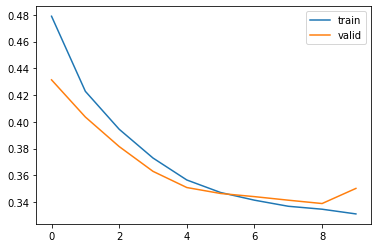

In [53]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

In [54]:
y_pred1_train= model1.predict(X_train)
for i in range(len(y_train)):
    if y_pred1_train[i]>0.5:
        y_pred1_train[i]=1 
    else:
        y_pred1_train[i]=0
cm1_train = confusion_matrix(y_train,y_pred1_train)

model1_train_perf = model_performance(
    cm1_train
)
print("train performance:")
model1_train_perf

train performance:


,Accuracy,Recall,Precision,F1
0,0.861512,0.576512,0.684122,0.625724


- Model achieves an accuracy of 0.814
- Recall is close which is agood
- Precision and F1 score are very low on the training data data

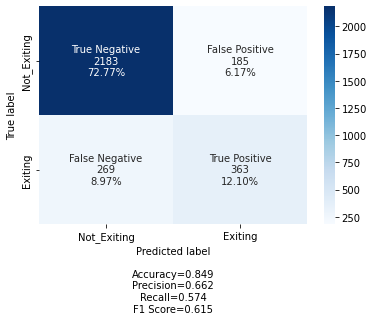

In [55]:
## Confusion Matrix on unsee test set
y_pred1 = model1.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm1=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exiting','Exiting']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [56]:
model1_test_perf = model_performance(
    cm1
)
print("test performance:")
model1_test_perf

test performance:


,Accuracy,Recall,Precision,F1
0,0.848667,0.574367,0.662409,0.615254


- Model shows greater Accuracy and and significat improvement in Precision on the testing data
- Recall has dropped significantly as well as the f1 score

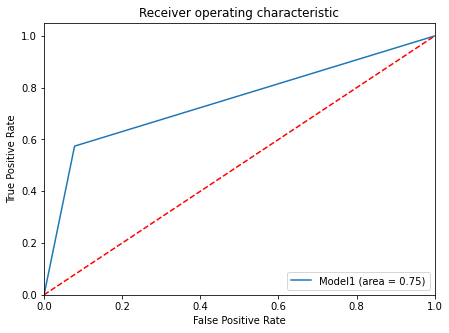

In [57]:
model1_roc_auc_test = roc_auc_score(y_test, y_pred1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Model1 (area = %0.2f)" % model1_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

- Attempting to use a threshold to help the recall

Optimal Threshold using ROC-AUC

In [58]:
fpr, tpr, thresholds = roc_curve(y_train, model1.predict(X_train))

optimal_idx = np.argmax(tpr - fpr)
model1_optimal_threshold_auc_roc = thresholds[optimal_idx]
print(model1_optimal_threshold_auc_roc)

0.28411308


- Found optimal threshold to be 0.21056086

In [59]:
model1_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    model1, X_train, y_train, threshold=model1_optimal_threshold_auc_roc
)
print("train performance:")
model1_train_perf_threshold_auc_roc

train performance:


,Accuracy,Recall,Precision,F1
0,0.801201,0.765836,0.503274,0.607395


- Applying threshold to the training data shows a huge drop in accuracy and precision in favor of very high recall

In [60]:
model1_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    model1, X_test, y_test, threshold=model1_optimal_threshold_auc_roc
)
print("test performance:")
model1_test_perf_threshold_auc_roc

test performance:


,Accuracy,Recall,Precision,F1
0,0.795,0.77057,0.508882,0.612964


- Applying threshold to testing data shows significant improvement compared to training data.
- Lower accuracy and precision compared to non-threshold testing data however higher f1 and recall scores

## Model 2

### Building Model 2

- We may be able to improve the model by balancing class weights, there are significantly more customers that did not leave, we may be to make more accurate predicitons

In [61]:
y_array = np.array([y_train.iloc[i] for i in range(len(y_train))])

In [62]:

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y = y_array)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6256258941344778, 1: 2.490035587188612}

In [63]:
# Using the same parameters/build as model 1
model2 = model1

In [64]:
model2.fit(X_train,y_train,batch_size=32,epochs=10, class_weight=class_weights, validation_split=0.2)


Epoch 1/10
175/175 [==============================] - 1s 3ms/step - loss: 0.4588 - Accuracy: 0.7979 - val_loss: 0.4381 - val_Accuracy: 0.8007
Epoch 2/10
175/175 [==============================] - 1s 3ms/step - loss: 0.4481 - Accuracy: 0.7997 - val_loss: 0.4147 - val_Accuracy: 0.8164
Epoch 3/10
175/175 [==============================] - 1s 3ms/step - loss: 0.4435 - Accuracy: 0.7951 - val_loss: 0.4596 - val_Accuracy: 0.7857
Epoch 4/10
175/175 [==============================] - 1s 3ms/step - loss: 0.4418 - Accuracy: 0.8029 - val_loss: 0.4559 - val_Accuracy: 0.7900
Epoch 5/10
175/175 [==============================] - 0s 3ms/step - loss: 0.4369 - Accuracy: 0.8035 - val_loss: 0.4377 - val_Accuracy: 0.7986
Epoch 6/10
175/175 [==============================] - 0s 3ms/step - loss: 0.4348 - Accuracy: 0.8015 - val_loss: 0.4497 - val_Accuracy: 0.8021
Epoch 7/10
175/175 [==============================] - 0s 3ms/step - loss: 0.4319 - Accuracy: 0.8006 - val_loss: 0.4428 - val_Accuracy: 0.7979
Epoch 

In [65]:
y_pred2_train= model2.predict(X_train)
for i in range(len(y_train)):
    if y_pred2_train[i]>0.5:
        y_pred2_train[i]=1 
    else:
        y_pred2_train[i]=0
cm2_train = confusion_matrix(y_train,y_pred2_train)

model2_train_perf = model_performance(
    cm2_train
)
print("train performance:")
model2_train_perf

train performance:


,Accuracy,Recall,Precision,F1
0,0.808489,0.784342,0.515194,0.621896


- Training model has exact same perfomance as Default NN

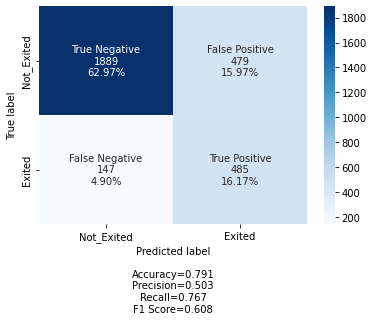

In [66]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred2 = model2.predict(X_test)
for i in range(len(y_test)):
    if y_pred2[i]>0.5:
        y_pred2[i]=1 
    else:
        y_pred2[i]=0



cm2=confusion_matrix(y_test, y_pred2)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [67]:
model2_test_perf = model_performance(
    cm2
)
print("test performance:")
model2_test_perf

test performance:


,Accuracy,Recall,Precision,F1
0,0.791333,0.767405,0.503112,0.607769


- Shows slightly better Accuracy and Precision compared to Default NN with threshold
- Show highers higher recall than the Default  NN

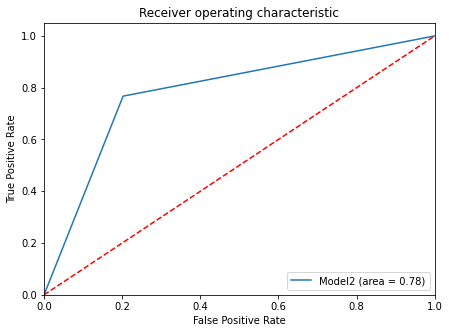

In [68]:
model2_roc_auc_test = roc_auc_score(y_test, y_pred2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Model2 (area = %0.2f)" % model2_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

- Finding optimal threshold

### ROC-AUC Optimal Threshold

In [69]:
fpr, tpr, thresholds = roc_curve(y_train, model2.predict(X_train))

optimal_idx2 = np.argmax(tpr - fpr)
model2_optimal_threshold_auc_roc = thresholds[optimal_idx2]
print(model2_optimal_threshold_auc_roc)

0.5243045


- Optimal Threshold is 0.46501952

In [70]:
model2_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    model2, X_train, y_train, threshold=model2_optimal_threshold_auc_roc
)
print("train performance:")
model2_train_perf_threshold_auc_roc

train performance:


,Accuracy,Recall,Precision,F1
0,0.819923,0.768683,0.53598,0.631579


- Better Recall than the training performance of the Default NN
- Higher Precision and Accuracy than Default NN with threshold
- Lower Precision and Accuracy then Weighted NN, higher recall however.

In [71]:
model2_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    model2, X_test, y_test, threshold=model2_optimal_threshold_auc_roc
)
print("test performance:")
model2_test_perf_threshold_auc_roc

test performance:


,Accuracy,Recall,Precision,F1
0,0.800333,0.746835,0.518112,0.611795


- Lower Accuracy and Precision compared to Weighted NN, higher recall
- Lower Accuracy and Precision compared to Default NN with threshold
- Higher Recall compared to Default NN, lower Accuracy and Precision

## Gridsearch

In [72]:
def create_model(learn_rate=0.001, neurons_1=1, neurons_2=1, neurons_3=1):
  # create model
  model = tf.keras.Sequential()
  model.add(InputLayer(input_shape=X_train.shape[1]))
  model.add(Dense(neurons_1, activation = 'relu'))
  model.add(Dense(neurons_2, activation = 'relu'))
  model.add(Dense(neurons_3, activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))

	# Compile model
  optimizer = Adam(learning_rate=learn_rate)
  model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
  return model

- Creating model to be optimized by gridsearch

In [73]:
neural_network = KerasClassifier(build_fn=create_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


- Applied to a classifier for gridsearch

In [74]:
# define the grid search parameters
hyperparameters = dict(learn_rate = [0.001, 0.01], 
                       class_weight = [class_weights, None],
                       neurons_1= [16,32],
                       neurons_2= [8,16],
                       neurons_3= [4,8]) 
hyperparameters

{'class_weight': [{0: 0.6256258941344778, 1: 2.490035587188612}, None],
 'learn_rate': [0.001, 0.01],
 'neurons_1': [16, 32],
 'neurons_2': [8, 16],
 'neurons_3': [4, 8]}

In [75]:
# Conduct Grid Search

# Create grid search
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters, n_jobs=-1, cv=5)

# Fit grid search
grid_result = grid.fit(X_train, y_train)

219/219 [==============================] - 1s 2ms/step - loss: 0.4046 - accuracy: 0.8325


- Created a dictionary of Hyperparameters to search
- fit Gridsearch model

In [76]:
# Find best model's hyperparameters
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

0.639568 (0.044325) with: {'class_weight': {0: 0.6256258941344778, 1: 2.490035587188612}, 'learn_rate': 0.001, 'neurons_1': 16, 'neurons_2': 8, 'neurons_3': 4}
0.679436 (0.022223) with: {'class_weight': {0: 0.6256258941344778, 1: 2.490035587188612}, 'learn_rate': 0.001, 'neurons_1': 16, 'neurons_2': 8, 'neurons_3': 8}
0.646996 (0.030582) with: {'class_weight': {0: 0.6256258941344778, 1: 2.490035587188612}, 'learn_rate': 0.001, 'neurons_1': 16, 'neurons_2': 16, 'neurons_3': 4}
0.646123 (0.046825) with: {'class_weight': {0: 0.6256258941344778, 1: 2.490035587188612}, 'learn_rate': 0.001, 'neurons_1': 16, 'neurons_2': 16, 'neurons_3': 8}
0.629713 (0.071015) with: {'class_weight': {0: 0.6256258941344778, 1: 2.490035587188612}, 'learn_rate': 0.001, 'neurons_1': 32, 'neurons_2': 8, 'neurons_3': 4}
0.674431 (0.020654) with: {'class_weight': {0: 0.6256258941344778, 1: 2.490035587188612}, 'learn_rate': 0.001, 'neurons_1': 32, 'neurons_2': 8, 'neurons_3': 8}
0.686288 (0.034056) with: {'class_weig

- Best Parameters are using no classweight, learn_rate of 0.01, 32 nodes in neuron_1, 16 nodes in neuron_2, and 8 nodes in neuron_3.

## Final model

In [77]:
# create model
final_model = tf.keras.Sequential()
final_model.add(InputLayer(input_shape=X_train.shape[1]))
final_model.add(Dense(grid_result.best_params_['neurons_1'], activation = 'relu'))
final_model.add(Dense(grid_result.best_params_['neurons_2'], activation = 'relu'))
final_model.add(Dense(1, activation='relu'))

# Compile model
optimizer = Adam(learning_rate=grid_result.best_params_['learn_rate'])
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = final_model.fit(X_train, y_train, epochs = 100, verbose = 1, validation_split=0.2) # batch_size = grid_result.best_params_['batch_size']

Epoch 1/100
175/175 [==============================] - 1s 3ms/step - loss: 0.8293 - accuracy: 0.7468 - val_loss: 0.5739 - val_accuracy: 0.7786
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 0.5593 - accuracy: 0.7745 - val_loss: 0.5251 - val_accuracy: 0.7764
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 0.5274 - accuracy: 0.7901 - val_loss: 0.5609 - val_accuracy: 0.8021
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 0.5026 - accuracy: 0.8072 - val_loss: 0.5047 - val_accuracy: 0.8050
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 0.5512 - accuracy: 0.7770 - val_loss: 0.5112 - val_accuracy: 0.7857
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 0.5101 - accuracy: 0.8111 - val_loss: 0.4695 - val_accuracy: 0.8200
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 0.4602 - accuracy: 0.8228 - val_loss: 0.4472 - val_accuracy: 0.8257

In [78]:
y_pred3_train= final_model.predict(X_train)
for i in range(len(y_train)):
    if y_pred3_train[i]>0.5:
        y_pred3_train[i]=1 
    else:
        y_pred3_train[i]=0
cm3_train = confusion_matrix(y_train,y_pred3_train)

model3_train_perf = model_performance(
    cm3_train
)
print("train performance:")
model3_train_perf

train performance:


,Accuracy,Recall,Precision,F1
0,0.869516,0.483986,0.78341,0.598328


- Highest Accuracy and Precision among all training models of neural networks
- Lowest Recall among all training models of neural networks

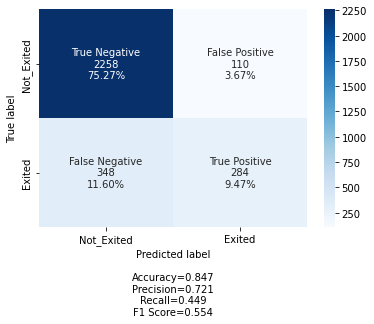

In [79]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred3 = final_model.predict(X_test)
for i in range(len(y_test)):
    if y_pred3[i]>0.5:
        y_pred3[i]=1 
    else:
        y_pred3[i]=0



cm3=confusion_matrix(y_test, y_pred3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [80]:
model3_test_perf = model_performance(
    cm3
)
print("test performance:")
model3_test_perf

test performance:


,Accuracy,Recall,Precision,F1
0,0.847333,0.449367,0.720812,0.553606


- In test perfomance does slightly worse than Default NN on all metrics

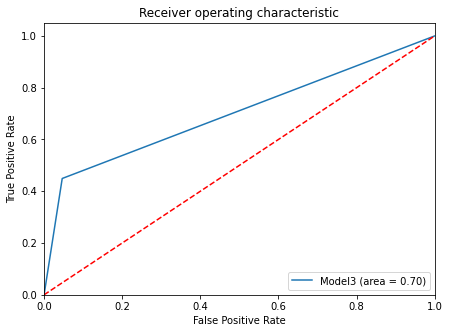

In [81]:
model3_roc_auc_test = roc_auc_score(y_test, y_pred3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Model3 (area = %0.2f)" % model3_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Finding optimal threshold

In [82]:
fpr, tpr, thresholds = roc_curve(y_train, final_model.predict(X_train))

optimal_idx3 = np.argmax(tpr - fpr)
model3_optimal_threshold_auc_roc = thresholds[optimal_idx3]
print(model3_optimal_threshold_auc_roc)

0.20961958


- Optimal Threshold is 0.20061302

In [83]:
model3_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    final_model, X_train, y_train, threshold=model3_optimal_threshold_auc_roc
)
print("train performance:")
model3_train_perf_threshold_auc_roc

train performance:


,Accuracy,Recall,Precision,F1
0,0.791482,0.813523,0.488462,0.610414


- Higher recall than Gridsearch NN without threshold, worse among other metrics

In [84]:
model3_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    final_model, X_test, y_test, threshold=model3_optimal_threshold_auc_roc
)
print("test performance:")
model3_test_perf_threshold_auc_roc

test performance:


,Accuracy,Recall,Precision,F1
0,0.778,0.778481,0.483301,0.596364


- Precision and Accuracy in Test data suffers copared to Gridsearch NN without threshold
- Recall improved significantly

## Comparing all models

In [85]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model1_train_perf.T,
        model1_train_perf_threshold_auc_roc.T,
        model2_train_perf.T,
        model2_train_perf_threshold_auc_roc.T,
        model3_train_perf.T,
        model3_train_perf_threshold_auc_roc.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Default Neural Network",
    "Default Neural Network with threshold",
    "Weighted Neural Network",
    "Weighted Neural Network with threshold",
    "Gridsearch Neural Network",
    "Gridsearch Neural Network with threshold",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Default Neural Network,Default Neural Network with threshold,Weighted Neural Network,Weighted Neural Network with threshold,Gridsearch Neural Network,Gridsearch Neural Network with threshold
Accuracy,0.861512,0.801201,0.808489,0.819923,0.869516,0.791482
Recall,0.576512,0.765836,0.784342,0.768683,0.483986,0.813523
Precision,0.684122,0.503274,0.515194,0.535980,0.783410,0.488462
F1,0.625724,0.607395,0.621896,0.631579,0.598328,0.610414


- In the test Data Grisdsearch NN has the highest Accuracy and Precision
- Default NN with Threshold has the highest Recall and F1 score


In [86]:
# training performance comparison

models_test_comp_df = pd.concat(
    [
        model1_test_perf.T,
        model1_test_perf_threshold_auc_roc.T,
        model2_test_perf.T,
        model2_test_perf_threshold_auc_roc.T,
        model3_test_perf.T,
        model3_test_perf_threshold_auc_roc.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Default Neural Network",
    "Default Neural Network with threshold",
    "Weighted Neural Network ",
    "Weighted Neural Network with threshold",
    "Gridsearch Neural Network ",
    "Gridsearch Neural Network with threshold",
]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Default Neural Network,Default Neural Network with threshold,Weighted Neural Network,Weighted Neural Network with threshold,Gridsearch Neural Network,Gridsearch Neural Network with threshold
Accuracy,0.848667,0.795000,0.791333,0.800333,0.847333,0.778000
Recall,0.574367,0.770570,0.767405,0.746835,0.449367,0.778481
Precision,0.662409,0.508882,0.503112,0.518112,0.720812,0.483301
F1,0.615254,0.612964,0.607769,0.611795,0.553606,0.596364


- In testing Data Defaull NN has the highest Accuracy, Precision
- Weighted NN with threshold has the highest Recall 
- Weighted NN has highest F1 score

### Improvements
- Different Hyperparameters can be tuned to see if there would be better outcome
- Randomsearch may be able to get a better result
- Resampling technicques could be applied to balance the data

## Conclusions

- Because we want a high recall the Weighted NN with threshold offers that along with decent accuracy and should be the model of choice. 
- Improvements could be made to the model to achieve higher accuracy and recall
